### (1) Import

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

### (2) Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self, z_sim=10, in_chan=1, hidden_dim=64):
    super(Generator, self).__init__()
    self.z_dim = z_dim
    # Build the neural network
    self.gen = nn.Sequential(
        self.gen_block(z_dim, hidden_dim * 4), # 첫 번째는 3, 2
        self.gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1), # 두 번째는 4, 1
        self.gen_block(hidden_dim * 2, hidden_dim), # 세 번째는 3, 2
        self.gen_block(hidden_dim, in_chan, kernel_size=4, final_layer=True), # 마지막에는 4, 2
    )

  # def gen_block
  def gen_block(self, in_channel, out_channel, kernel_size=3, stride=2, final_layer=False):
    if not final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride),
          nn.BatchNorm2d(out_channel),
          nn.ReLU(inplace=True),
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride),
          nn.Tanh(), # tanh => -1 ~ 1까지 나오므로 값을 제한하기 위해 사용함
      )

  def unsqueeze_noise(self, noise):
    return noise.view(len(noise), self.z_dim, 1, 1)

  def forward(self, noise):
    x = self.unsqueeze_noise(noise)
    return self.gen(x)

### (3) Critic

In [ ]:
class Critic(nn.Module):
  def __init__(self, im_chan=1, hidden_dim=64):
    super(Critic, self).__init__()
    self.crit = nn.Sequential(
        self.crit_block(im_chan, hidden_dim),
        self.crit_block(hidden_dim, hidden_dim * 2),
        self.crit_block(hidden_dim * 2, 1, final_layer = True),
    )

  def crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
    if not final_layer:
      return nn.Sequential(
          nn.Conv2d(input_channels, output_channels, kernel_size, stride),
          nn.BatchNorm2d(output_channels),
          nn.LeakyReLU(0.2, inplace = True),
      )
    else:
      return nn.Sequential(
          nn.Conv2d(input_channels, output_channels, kernel_size, stride),
      )

  def forward(self, image):
    crit_pred = self.crit(image)
    return crit_pred.view(len(crit_pred), -1)
    

### (4) Noise 생성

In [ ]:
def get_noise(n_samples, z_dim, device="cpu"):
  return torch.randn(n_samples, z_dim, device=device)

### (5) 기타

### (5-1) 파라미터 세팅 & 초기화

In [ ]:
n_epochs = 100
z_dim = 64
display_step = 50
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = "cpu"

### (5-2) 데이터 로딩

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,)),                                  
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### (5-3) optimizer

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

### (6) gradient 계산

In [ ]:
def get_gradient(crit, real, fake, epsilon):
  # Mix the images together
  mixed_images = real * epsilon + fake * (1 - epsilon)

  # Calculate the critic's scores on the mixed images
  mixed_scores = crit(mixed_images)

  # Take the gradient of the scores with respect to the images
  gradient = torch.autograd.grad(
      inputs = mixed_images,
      outputs = mixed_scores,

      grad_outputs = torch.ones_like(mixed_scores),
      create_graph = True,
      retain_graph = True,
  )[0]
  return gradient

### (6-1) Gradient penalty

In [ ]:
def gradient_penalty(gradient):
  # Flatten the gradients so that each row captures one image
  gradient = gradient.view(len(gradient), -1)

  # Calculate the magnitude of every row
  gradient_norm = gradient.norm(2, dim = 1)

  # Penalize the mean squared distance of the gradient norms from 1
  penalty = torch.mean((gradient_norm - 1) ** 2)
  return penalty

### (7) Loss 함수 계산

In [ ]:
def get_gen_loss(crit_fake_pred):
  gen_loss = -1. * torch.mean(crit_fake_pred)
  return gen_loss

def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
  crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
  return crit_loss

### (8) Image display

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
  image_unflat = image_tensor.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

### (9) Training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 50, generator_loss : -0.10353611328173429, critic_loss : 1.8490017565190788


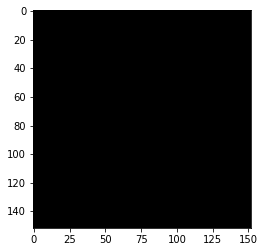

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


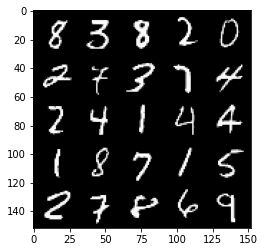

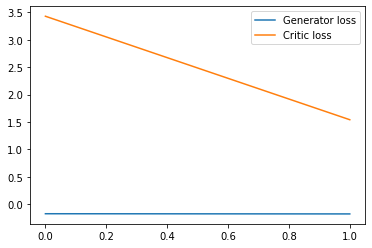

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 100, generator_loss : 1.0713277895748616, critic_loss : -1.7558410922586918


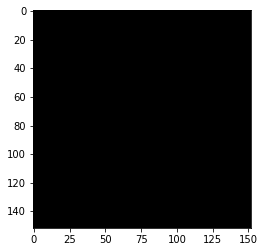

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


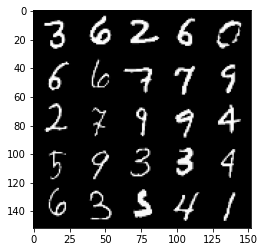

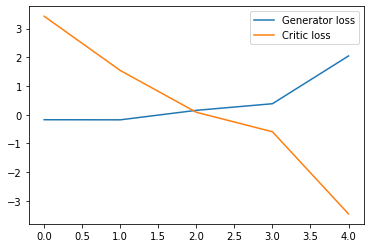

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 150, generator_loss : 2.265170530080795, critic_loss : -10.67081480407715


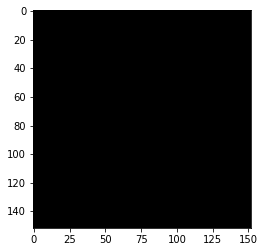

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


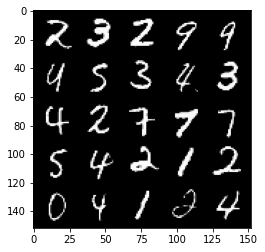

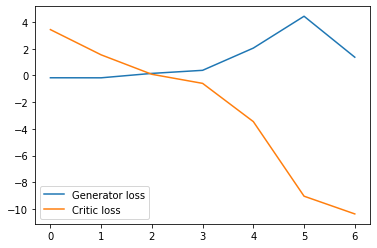

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 200, generator_loss : -2.046863325238228, critic_loss : -25.264341419219964


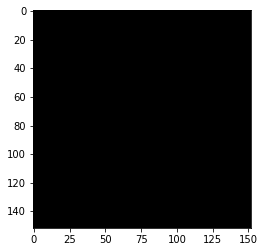

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


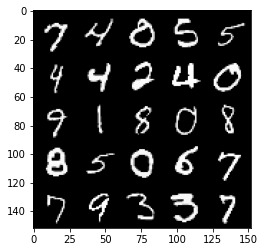

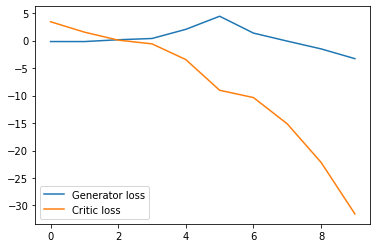

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 250, generator_loss : -3.7073946809768676, critic_loss : -53.75539970397949


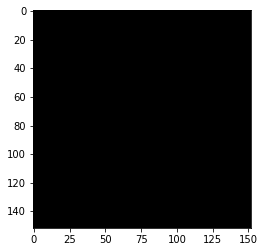

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


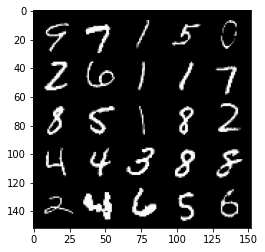

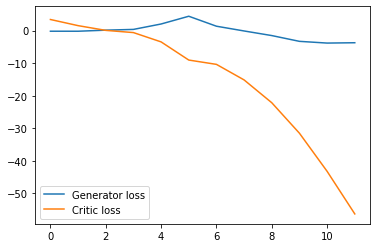

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 300, generator_loss : -1.6620253912359475, critic_loss : -92.62947084045408


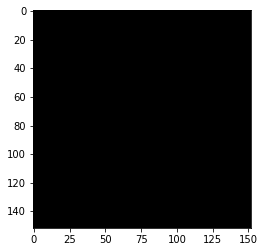

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


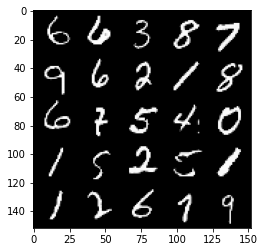

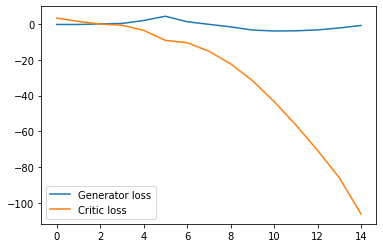

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 350, generator_loss : 3.1967882841825483, critic_loss : -137.63260556030272


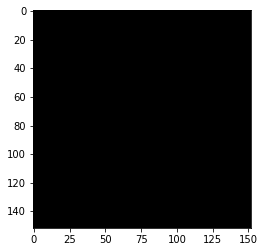

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


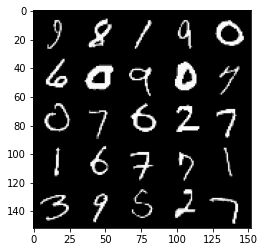

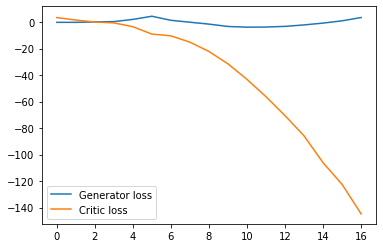

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 400, generator_loss : 11.294957065582276, critic_loss : -191.49076068115244


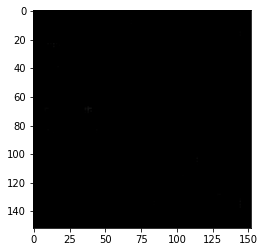

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


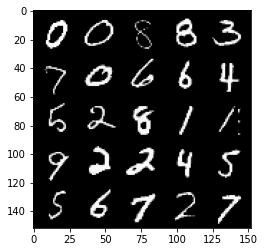

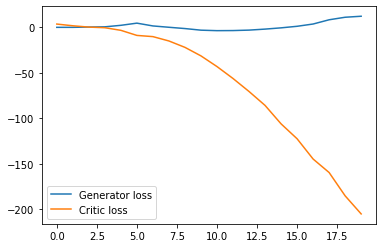

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 450, generator_loss : 17.46093542098999, critic_loss : -244.20614678955073


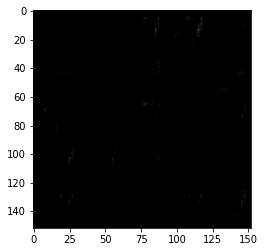

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


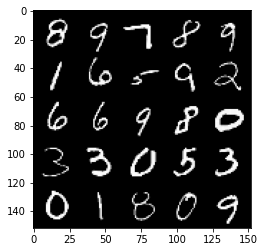

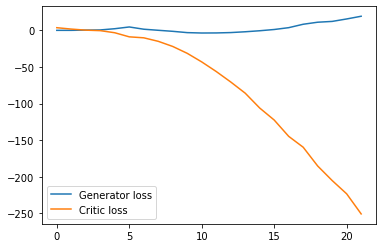

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 500, generator_loss : 19.23678356170654, critic_loss : -301.31730004882814


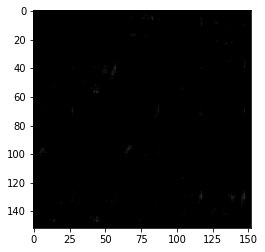

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


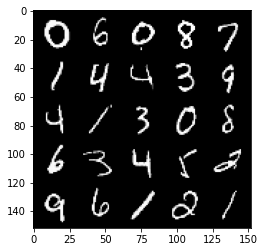

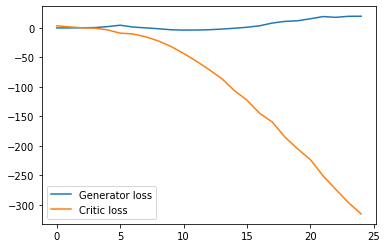

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 550, generator_loss : 18.911489276885987, critic_loss : -349.7981012878417


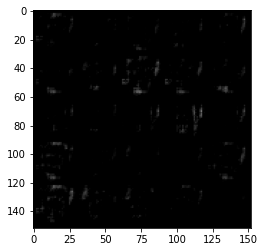

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


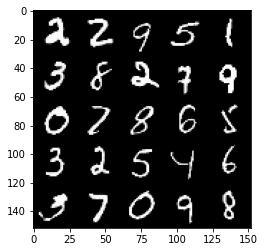

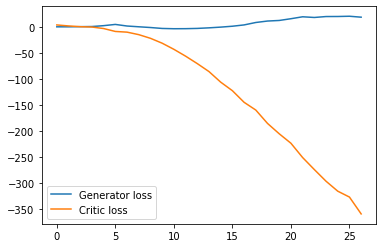

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 600, generator_loss : 17.047183556556703, critic_loss : -408.64272888183586


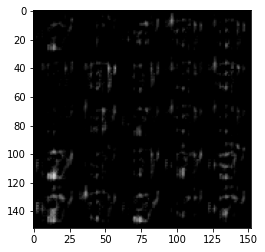

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


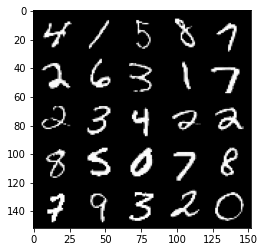

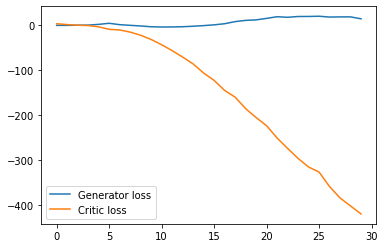

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 650, generator_loss : -17.092876152992247, critic_loss : -380.6358992004394


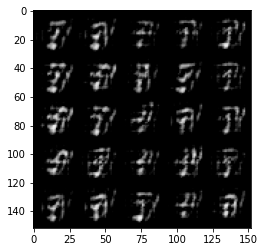

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


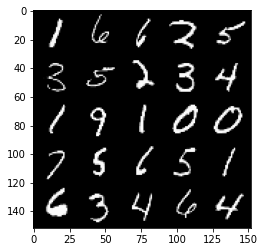

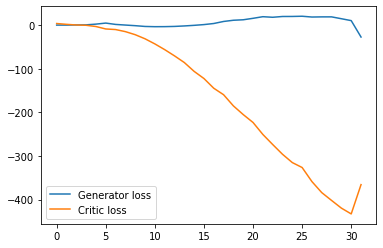

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 700, generator_loss : -26.604940662384035, critic_loss : -335.98366015625


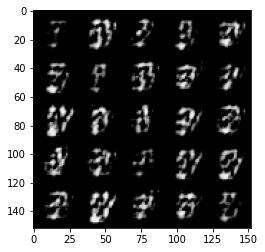

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


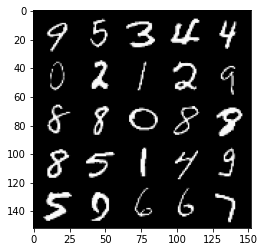

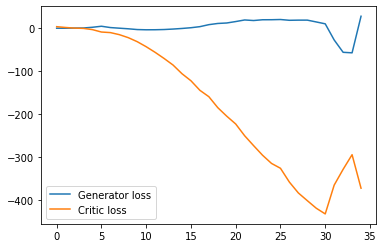

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 750, generator_loss : -2.585598044395447, critic_loss : -405.5679530029298


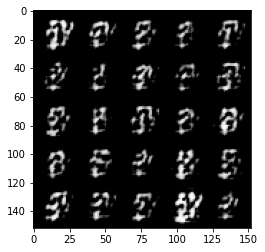

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


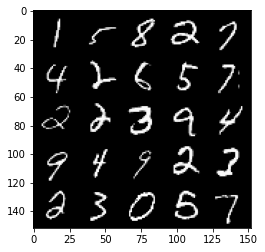

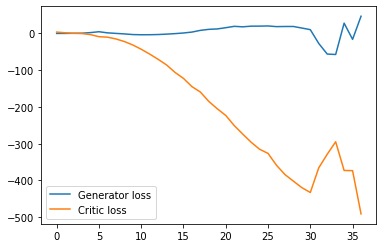

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 800, generator_loss : 1.8410618209838867, critic_loss : -351.6723511047364


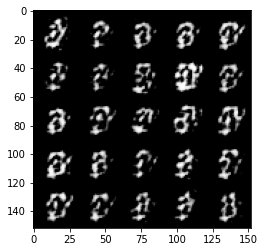

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


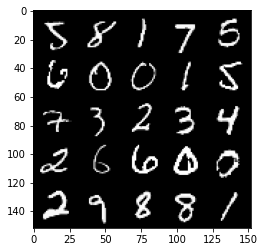

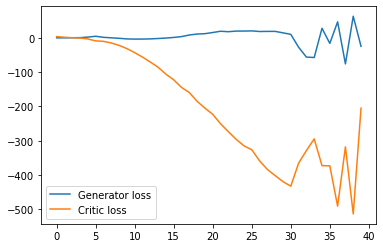

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 850, generator_loss : 29.670483524799348, critic_loss : -375.69885171508787


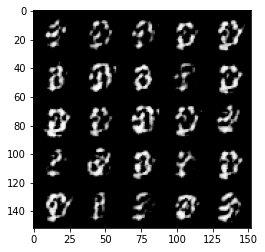

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


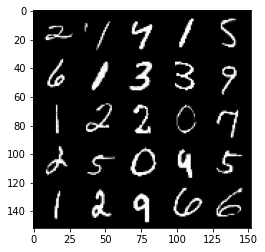

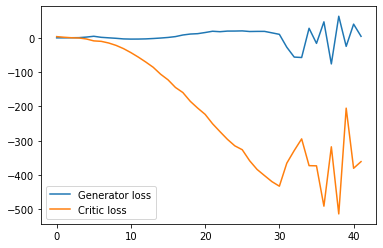

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 900, generator_loss : 10.397825288772584, critic_loss : -371.9179909057616


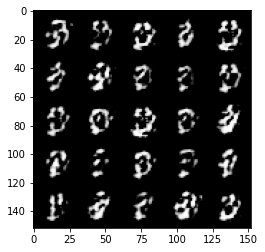

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


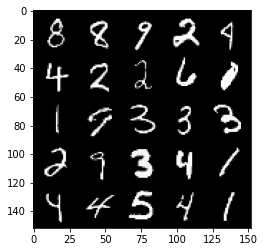

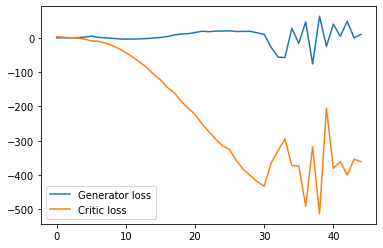

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 950, generator_loss : -6.5570384991168975, critic_loss : -300.4358690643311


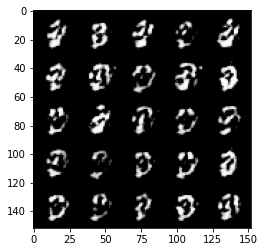

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


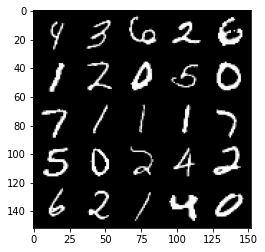

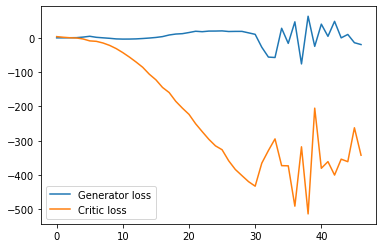

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1000, generator_loss : -11.121417469978333, critic_loss : -278.21894921875


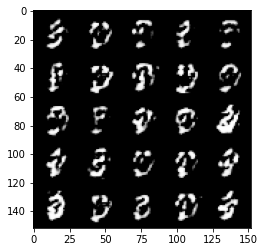

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


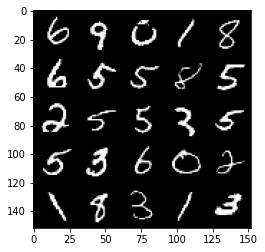

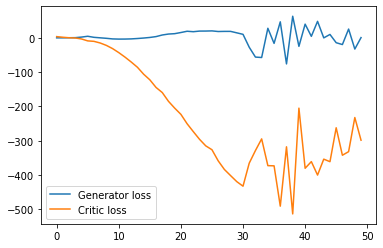

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1050, generator_loss : -6.076002689599991, critic_loss : -112.55809927368163


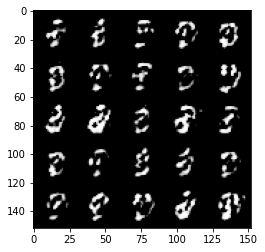

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


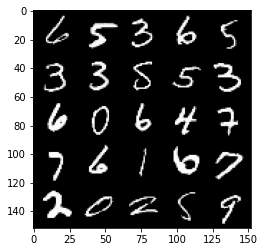

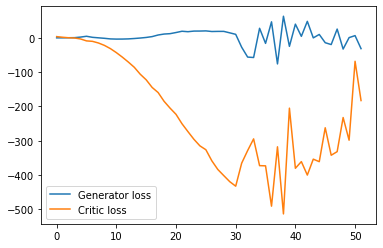

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1100, generator_loss : -33.92654716014862, critic_loss : -101.27980816650391


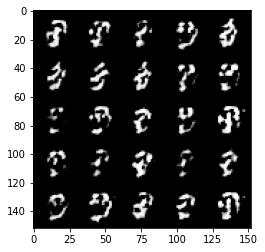

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


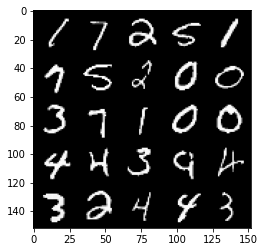

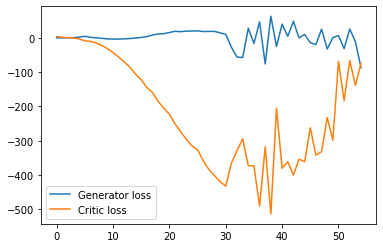

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1150, generator_loss : -34.81505178332329, critic_loss : -73.77456881713867


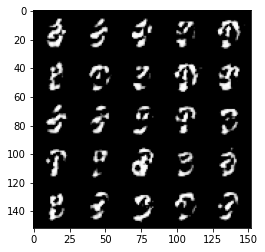

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


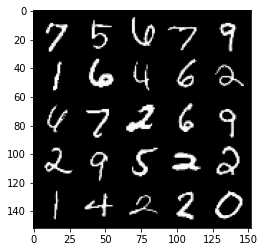

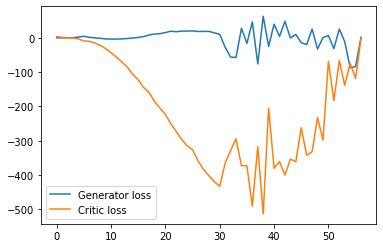

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1200, generator_loss : -36.14337623119354, critic_loss : -77.81956553649901


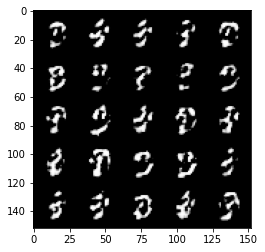

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


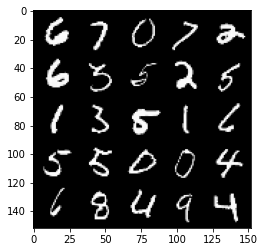

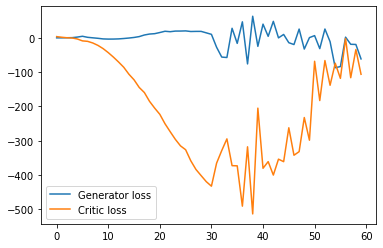

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1250, generator_loss : 25.728591804504394, critic_loss : 54.83342710113526


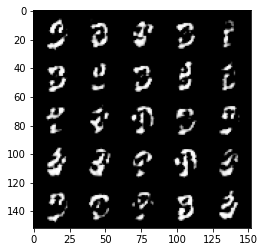

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


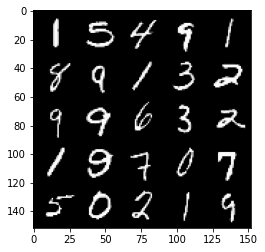

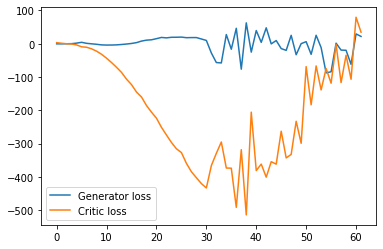

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1300, generator_loss : 24.273665466308593, critic_loss : 23.594222927093504


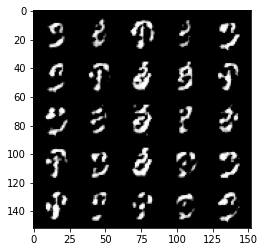

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


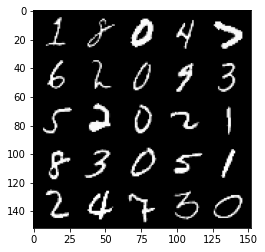

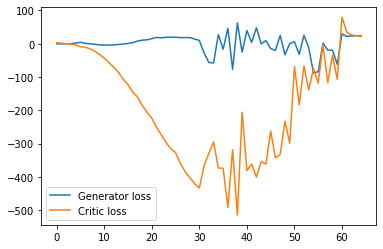

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1350, generator_loss : 24.30738063812256, critic_loss : 23.30655123138428


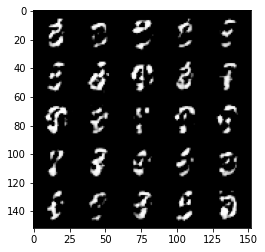

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


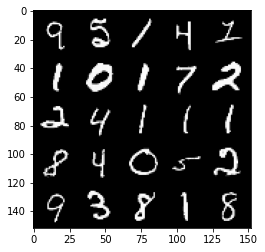

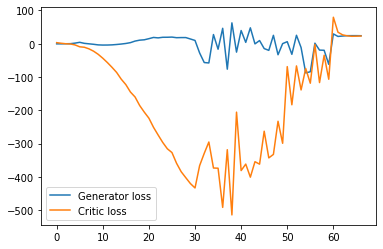

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1400, generator_loss : 23.964822273254395, critic_loss : 27.64948259735108


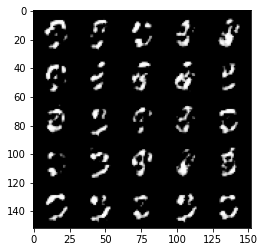

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


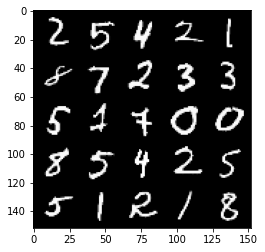

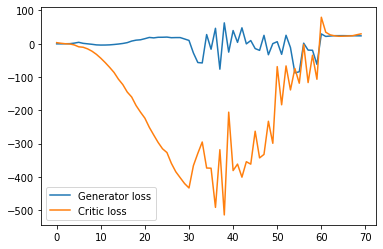

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1450, generator_loss : 23.667353477478027, critic_loss : 35.515373672485346


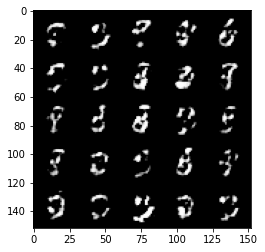

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


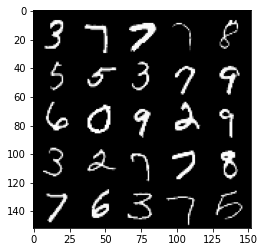

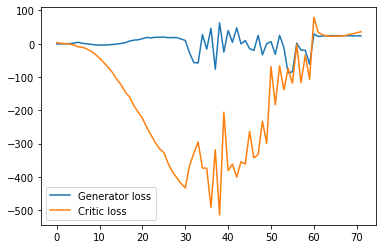

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1500, generator_loss : 21.79048545837402, critic_loss : 29.522027053833014


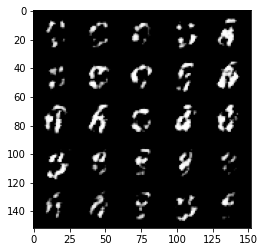

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


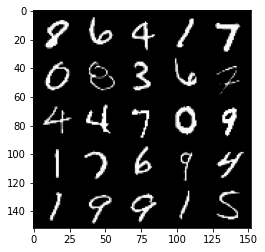

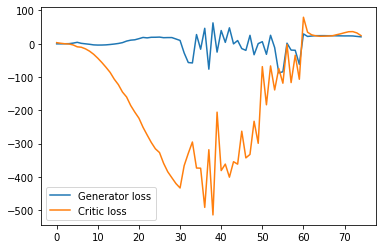

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1550, generator_loss : 18.64516410827637, critic_loss : 16.936346691131586


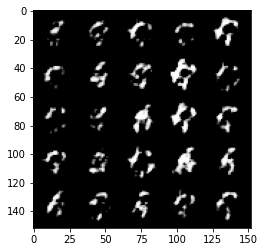

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


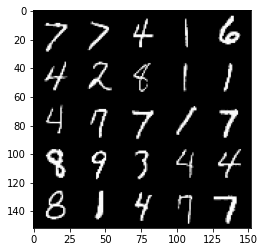

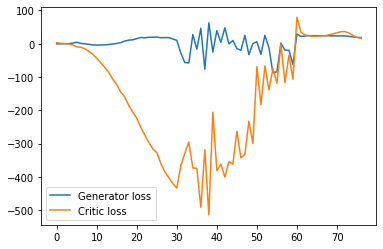

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1600, generator_loss : 16.028185958862306, critic_loss : 11.13586655044556


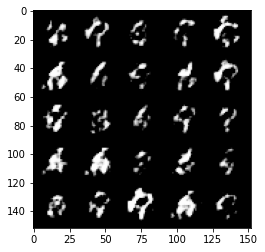

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


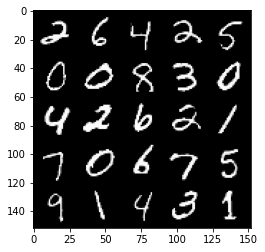

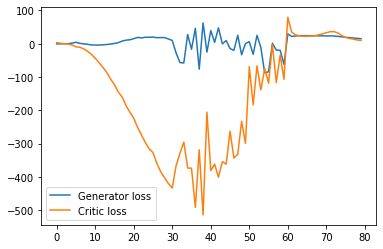

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1650, generator_loss : 14.403971576690674, critic_loss : 7.35528839111328


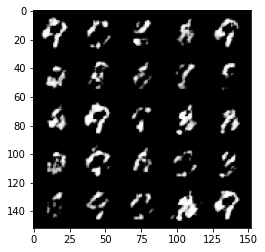

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


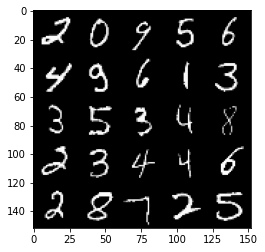

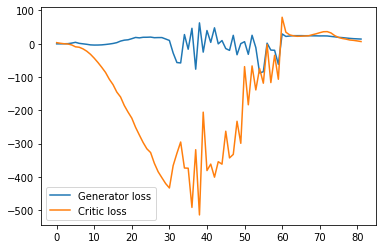

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1700, generator_loss : 13.23774522781372, critic_loss : 5.6055350074768056


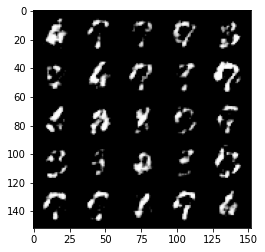

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


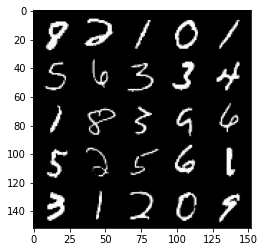

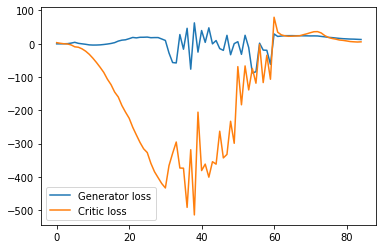

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1750, generator_loss : 11.779718208312989, critic_loss : 6.802397975921629


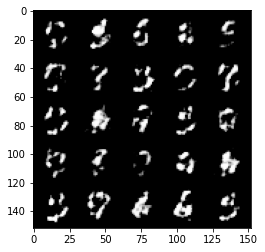

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


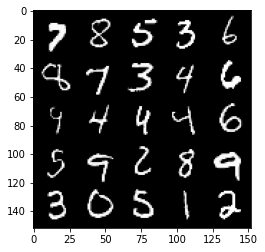

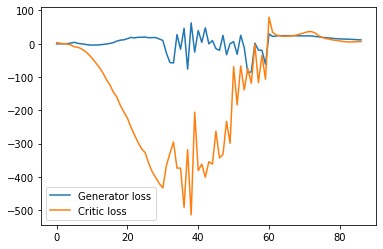

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step : 1800, generator_loss : 9.934145183563233, critic_loss : 7.120828550338745


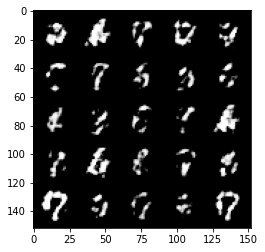

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


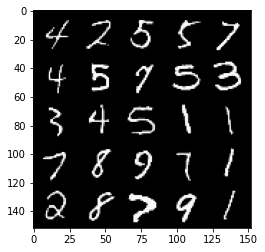

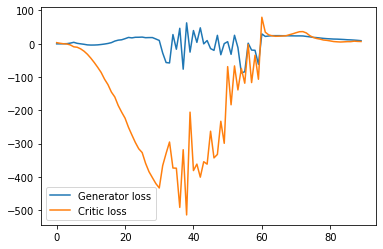

In [ ]:
cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
    # critic을 더 많이 train 시키고 나서 generator 로 넘어간다. 
    cur_batch_size = len(real)
    real = real.to(device)
    mean_iteration_critic_loss = 0
    for _ in range(crit_repeats):
      crit_opt.zero_grad()
      fake_noise = get_noise(cur_batch_size, z_dim, device=device)
      fake = gen(fake_noise)
      crit_fake_pred = crit(fake.detach())
      crit_real_pred = crit(real)

      epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
      gradient = get_gradient(crit, real, fake.detach(), epsilon)
      gp = gradient_penalty(gradient)
      crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

      mean_iteration_critic_loss += crit_loss.item() / crit_repeats
      crit_loss.backward(retain_graph=True)
      crit_opt.step()
    critic_losses += [mean_iteration_critic_loss]

    gen_opt.zero_grad()
    fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
    fake_2 = gen(fake_noise_2)
    crit_fake_pred = crit(fake_2)

    gen_loss = get_gen_loss(crit_fake_pred)
    gen_loss.backward()

    gen_opt.step()

    generator_losses += [gen_loss.item()]

    if cur_step % display_step == 0 and cur_step > 0:
      gen_mean = sum(generator_losses[-display_step:]) / display_step
      crit_mean = sum(critic_losses[-display_step:]) / display_step
      print(f"step : {cur_step}, generator_loss : {gen_mean}, critic_loss : {crit_mean}")
      show_tensor_images(fake)
      show_tensor_images(real)
      step_bins = 20
      num_examples = (len(generator_losses) // step_bins) * step_bins
      plt.plot(
          range(num_examples // step_bins),
          torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
          label = "Generator loss"
      )
      plt.plot(
          range(num_examples // step_bins),
          torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
          label = "Critic loss"
      )
      plt.legend()
      plt.show()
    cur_step += 1